In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\pyth

In [ ]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
import tensorflow as tf

cf = tf.ConfigProto()
cf.gpu_options.allow_growth = True
sess = tf.Session(config=cf)

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

In [4]:
import json
import skimage
class CalcMassDataset_no_normalize(utils.Dataset):

    def load_full_mammo_img(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        self.add_class("AbnormalType", 1, "Calc")
        self.add_class("AbnormalType", 2, "Mass")

        # Train or validation dataset?
        assert subset in ["Crop_train", "Crop_val","Crop_test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print("path join : " ,dataset_dir)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "annotation_skip02.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path,as_gray=True)
            height, width = image.shape[:2]

            self.add_image(
                "AbnormalType",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        shapes = info['id']
        #print(polygons)
        #print(len(polygons))
        #print(polygons[0]["name"])
        
        count = len(info["polygons"])
        #print(shapes)
        #print(count)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            #print(p)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_point_y'], p['all_point_x'])
            mask[rr, cc, i] = 1
            
        # Map class names to class IDs.
        #print('shapes',shapes)
        class_ids = np.array([self.class_names.index(info["polygons"][0]["name"])]*count)
        return mask.astype(np.bool), class_ids.astype(np.int32)
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

In [ ]:
ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Training dataset
dataset_train = CalcMassDataset_no_normalize()
dataset_train.load_full_mammo_img(CALCMASS_DIR, "Crop_train")
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

In [ ]:
ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Validation dataset
dataset_val = CalcMassDataset_no_normalize()
dataset_val.load_full_mammo_img(CALCMASS_DIR, "Crop_val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

In [5]:
ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Test dataset
dataset_test = CalcMassDataset_no_normalize()
dataset_test.load_full_mammo_img(CALCMASS_DIR, "Crop_test")
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

path join :  E:\DataSet\CBIS-DDSM\Crop_test
Images: 107
Classes: ['BG', 'Calc', 'Mass']


85
E:\DataSet\CBIS-DDSM\Crop_test\Mass-Test_P_01765_RIGHT_MLO_full.png


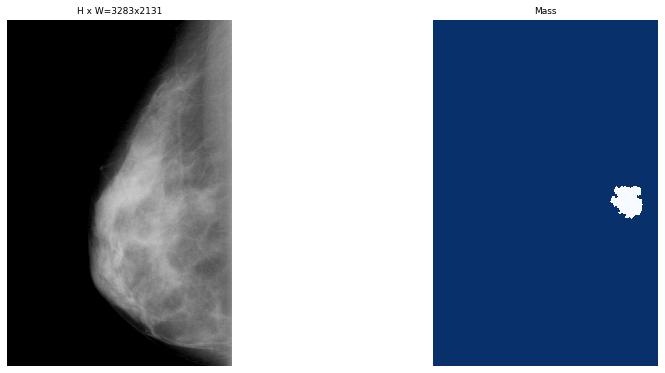

15
E:\DataSet\CBIS-DDSM\Crop_test\Calc-Test_P_01820_LEFT_MLO_full.png


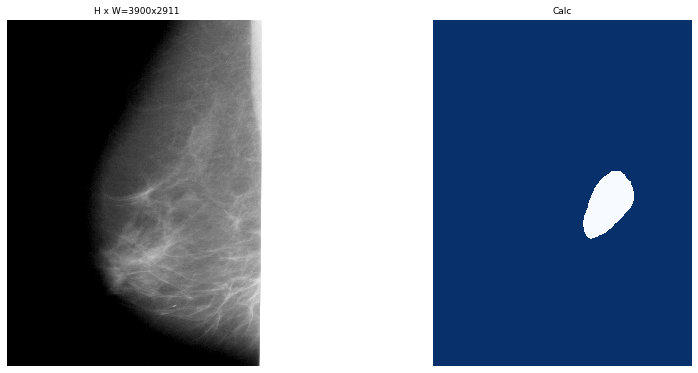

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 2)

#4개의 랜덤이미지를 보여줌
for image_id in image_ids:
    print(image_id)
    
    image = dataset_test.load_image(image_id)
    info =dataset_test.image_info
    print(info[image_id]["path"])
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names,limit=1)

# Create & Tranning model_tunning

In [9]:
class CalcMassConfig(Config):
    """
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_CHANNEL_COUNT = 3
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = CalcMassConfig()
#config.display()

# Callback 

In [ ]:
# image augmentation
import imgaug
from time import time
# set callback
from keras import callbacks

ct_callback = [callbacks.TensorBoard(log_dir=r"E:/DataSet/logs/Tensorboard/{}".format(time())),
              callbacks.CSVLogger(r"E:/DataSet/logs/csv_log/200604_00_log.csv")]

# Training

In [ ]:
# Create model in training mode
all_model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    all_model.load_weights(all_model.get_imagenet_weights(), by_name=True)
elif init_with == "last":
    # Load the last model you trained and continue training
    all_model.load_weights(all_model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
all_model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=300,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)]),
            custom_callbacks= ct_callback,
            layers='5+')

# Detection

In [17]:
class InferenceConfig(CalcMassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

model_path = os.path.join(r"logs", r"Segment_model.h5")
# model_path = os.path.join(ROOT_DIR, r'/logs')
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs\Segment_model.h5


In [15]:
model_path

'./logs\\*.h5'

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
d_list = [dataset_train,dataset_val,dataset_test]

for i in d_list:
    image_ids = np.random.choice(i.image_ids, 100)
    APs = []
    precisions_list=[]
    recalls_list=[]
    overlaps_list=[]

    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(i, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
        precisions_list.append(precisions)
        recalls_list.append(recalls)
        overlaps_list.append(overlaps)

    print(i,"mAP: ", np.mean(APs))

81
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  218.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4059.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  361.00000  max:  442.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


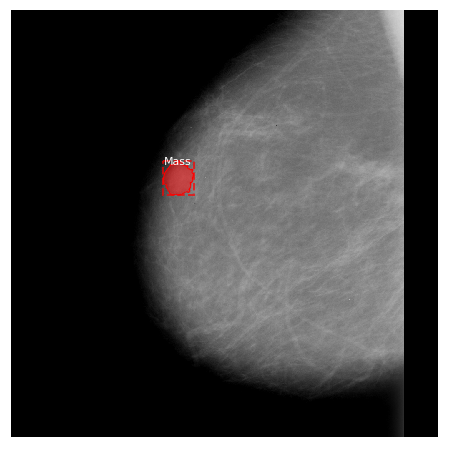

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  114.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32

[0.9890745  0.82331365 0.75850993]
(1024, 1024, 3)


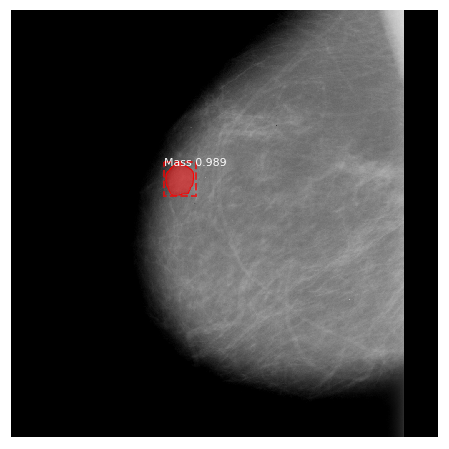

In [18]:
# Test on a random image
# well : 529
# 478
dataset = dataset_test
image_id = random.choice(dataset.image_ids)

# 랜덤으로 이미지 불러온 후 해당 이미지의 정보 출력
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

# 모델 예측
results = model.detect([original_image], verbose=1)

r = results[0]

scores_thold = r["scores"]>0.95
cnt = 0
for i in scores_thold:
    if i ==True:
        cnt+=1

# if cnt ==0:
#     print("not detect")
# else:
# 결과 출력
visualize.display_instances(original_image, r['rois'][:cnt], r['masks'][...,:cnt], r['class_ids'][:cnt], 
                            dataset.class_names, r['scores'][:cnt], ax=get_ax())
print(r['scores'])
print(r['masks'].shape)

In [2]:
dataset_test.class_names

NameError: name 'dataset_test' is not defined

In [19]:
# Get activations of a few sample layers
activations = model.run_graph([original_image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  114.10000  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   16.44898  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   18.64548  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -19.14030  max:   41.66420  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


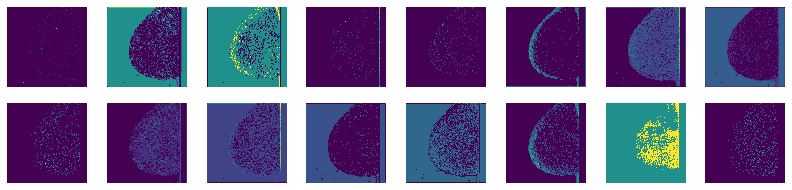

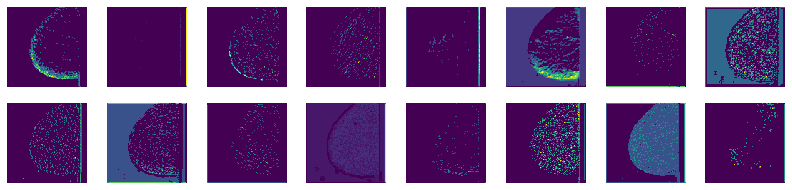

In [20]:
from mrcnn.visualize import display_images

# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:16], [2, 0, 1]), cols=8)
display_images(np.transpose(activations["res3c_out"][0,:,:,:16], [2, 0, 1]), cols=8)